*CREDIT DEFAULT PREDICTION:* **Part II - Extras**

# Begin

Install SHAP, this is a good tool to test explainability

In [ ]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.4/572.4 KB 4.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd

Download balanced sample. This was created in Part I

In [ ]:
df = pd.read_csv('https://github.com/coyoacan/abc/blob/2edf455c2489b5b5cf5a1ba92184e0842984e56d/DefaultPrediction_balanced_sample.zip?raw=true', compression='zip', encoding='utf-8')

In [ ]:
from timeit import default_timer # measure processing time :)
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder, MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder

Pipeline (again)

In [ ]:
new_cols = [col for col in df.columns if col != 'loan_status'] + ['loan_status']
df = df[new_cols] # new column order where target appears last
df = pd.concat([
        df.select_dtypes([], ['object']),
        df.select_dtypes(['object']).apply(pd.Series.astype, dtype='category')
        ], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24000 entries, 0 to 23999
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   loan_amnt             24000 non-null  int64   
 1   int_rate              24000 non-null  float64 
 2   installment           24000 non-null  float64 
 3   annual_inc            24000 non-null  float64 
 4   dti                   24000 non-null  float64 
 5   open_acc              24000 non-null  int64   
 6   pub_rec               24000 non-null  int64   
 7   revol_bal             24000 non-null  int64   
 8   revol_util            23986 non-null  float64 
 9   total_acc             24000 non-null  int64   
 10  mort_acc              24000 non-null  int64   
 11  pub_rec_bankruptcies  24000 non-null  int64   
 12  term                  24000 non-null  category
 13  sub_grade             24000 non-null  category
 14  emp_title             22463 non-null  category
 15  em

In [ ]:
X = df.drop('loan_status',axis=1)
y = df['loan_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=2022)

attributes_number = Pipeline(steps=[
    ('null_replacement', SimpleImputer(strategy='mean')),
    ('scaling', StandardScaler())
])

attributes_category = Pipeline(steps=[
    ('null_replacement', SimpleImputer(strategy='most_frequent')),
    ('encoding', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value = -1))
])

columns_number = X_train.select_dtypes(include='number').columns.to_list()
columns_category = X_train.select_dtypes(include='category').columns.to_list()

attributes_preprocess = ColumnTransformer(transformers=[
    ('number', attributes_number, columns_number),
    ('category', attributes_category, columns_category)
])

label_encoding = LabelEncoder()
y_train = label_encoding.fit_transform(y_train)
y_test = label_encoding.fit_transform(y_test)

# The model we previously chose

## Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


mean accuracy (train):  0.6507142857142857
mean accuracy (test):  0.6420833333333333
              precision    recall  f1-score   support

           0       0.63      0.68      0.65      3561
           1       0.66      0.61      0.63      3639

    accuracy                           0.64      7200
   macro avg       0.64      0.64      0.64      7200
weighted avg       0.64      0.64      0.64      7200



<Figure size 640x480 with 0 Axes>

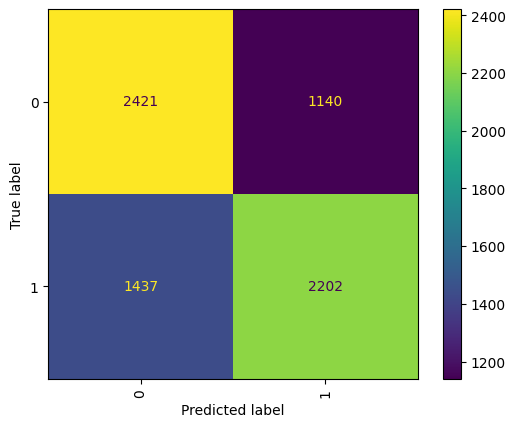

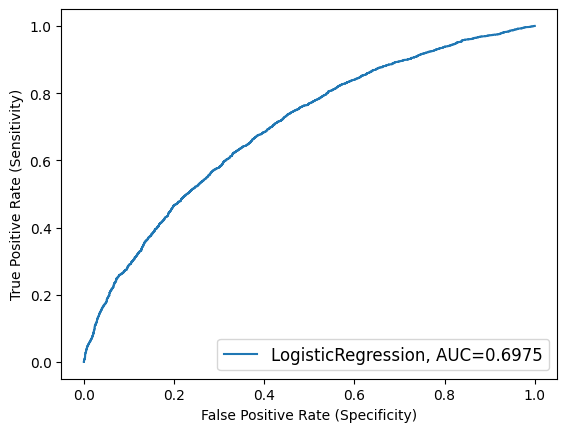

In [ ]:
#set up plotting area
plt.figure(0).clf()

# fit Decision Tree Classifier
model_pipeline = Pipeline(steps=[
                                  ('preprocesss', attributes_preprocess),
                                  ('model', LogisticRegression())                                 
])


model_pipeline.fit(X_train, y_train)

y_pred = model_pipeline.predict(X_test)
print("mean accuracy (train): ", model_pipeline.score(X_train,y_train))
print("mean accuracy (test): ", model_pipeline.score(X_test,y_test))
print(classification_report(y_test,y_pred))

ConfusionMatrixDisplay.from_predictions(y_test,y_pred, xticks_rotation='vertical')

plt.show()

y_pred = model_pipeline.predict_proba(X_test)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
auc = round(metrics.roc_auc_score(y_test, y_pred), 4)
plt.plot(fpr,tpr,label="LogisticRegression, AUC="+str(auc))
#add legend
plt.ylabel('True Positive Rate (Sensitivity)')
plt.xlabel('False Positive Rate (Specificity)')
plt.legend(loc=4,prop={'size': 12})


# Explainable AI

## Shapley-Values Summary Plot

This is the -Explainable AI- part. For more information look here: https://towardsdatascience.com/an-overview-of-model-explainability-in-modern-machine-learning-fc0f22c8c29a and here: https://www.sia-partners.com/en/insights/publications/interpretable-machine-learning. In a nutshell, this method is a very trending local approach based on game theory. It quantifies which part of a profit earned by a team each player must expect.

In [ ]:
import shap
from shap import LinearExplainer, Explanation
from shap.plots import waterfall
import matplotlib.pyplot as plt

Transform inputs into arrays and build the explainer.

In [ ]:
# Pre-process X_train please
x_Train = model_pipeline['preprocesss'].fit_transform(X_train)

# Pre-process X_test please
x_Test = model_pipeline['preprocesss'].fit_transform(X_test)

# Set the logistic regressor as the model of the pipeline
explainer = shap.LinearExplainer(model_pipeline['model'],x_Train)

Run the explainer, make a chart with the outputs

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


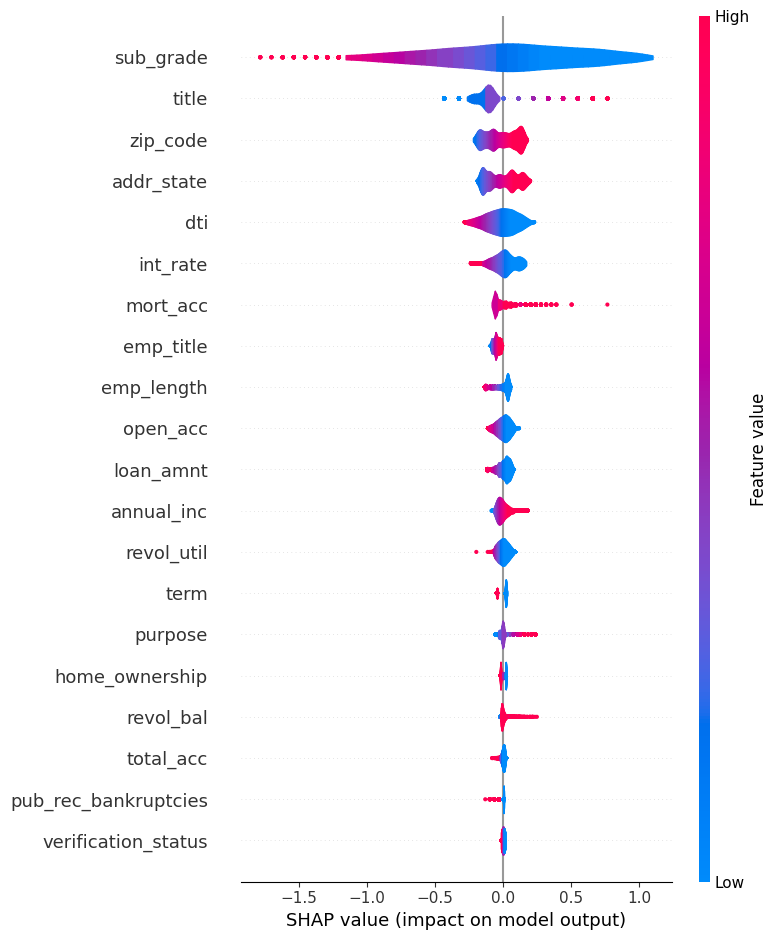

In [ ]:
shap_values = explainer.shap_values(x_Test)
shap.summary_plot(shap_values, x_Test, feature_names=X_train.columns, plot_type='violin')

## Waterfall Charts (First elements)

Create the explainer for testing values

In [ ]:
sv = explainer(x_Test)
exp = Explanation(sv.values,sv.base_values,feature_names=X_test.columns)

Guidance: create a y_pred to match predicted outcome with every chart. Notice a 0 will match waterfall chart ending inside the negative range (default), whereas a 1 will equal a waterfall ending inside the positive range (payment).

In [ ]:
y_pred = model_pipeline.predict(X_test) # First, predict
y_pred[0:21] # Then get the first 21 values

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1])

In [ ]:
y_test[0:21] # real desired outcome

array([1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1])

Warning ⚠, the following code creates several svg files in your notebook memory, if you want to use the svg files, download them to your local file. In this way you can create a presentation or a word document, if you need. This takes about 1 second per each iteration. (21 svg ~ 28 seconds)

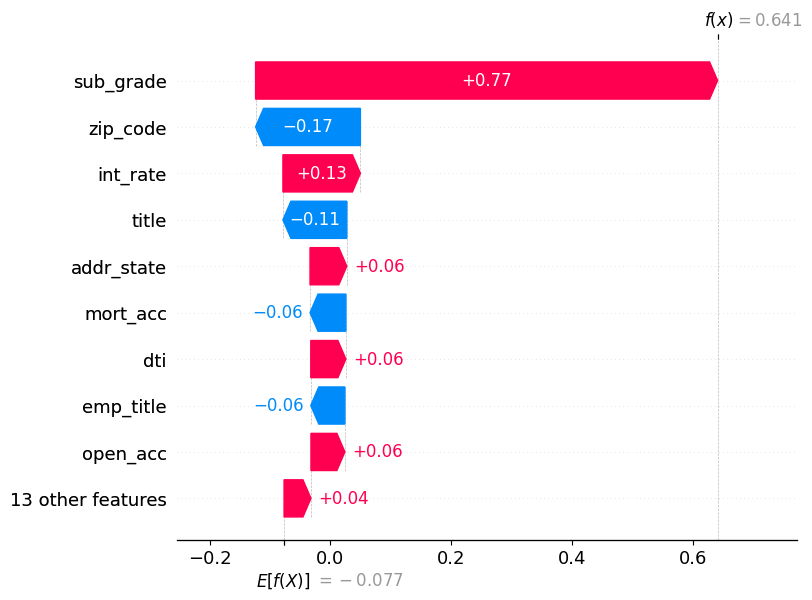

In [ ]:
for x in range(21):
  plt.clf()
  shap.plots.waterfall(exp[x],show=False)
  plt.savefig("Explainer_%d.svg" % x,dpi=150, bbox_inches='tight')

# User Interface

## Install tools

In [ ]:
# Install GRADIO please, this is the only I've learned
!pip install gradio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.8/15.8 MB 49.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 17.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 51.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 KB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 KB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.5/106.5 KB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.1/144.1 KB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 KB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 KB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.8/57.8 KB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 K

## Paving the Path for GRadio Interface

Import GRADIO for User Interface, Joblib to export model

In [ ]:
import joblib
import gradio as gr

Simulate saving the pipeline for production environment

In [ ]:
joblib.dump(model_pipeline, 'mypipeline.x')

['mypipeline.x']

Load pipeline and create a prediction function

In [ ]:
# Title of the user interface and helpful description
title ='Default Predictor Module'
description="""<center>
Please enter client information to predict -default- or continue allocating the loan
<img src="https://cdn.dribbble.com/users/43762/screenshots/1398115/ccu-superbowl---charge.gif" width=200px>
</center>"""

# Load the pipeline we previously saved
mypredictor = joblib.load('mypipeline.x')

# Prediction function

def run_my_model(x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21):
    ColumnNamesLlist = ['loan_amnt','int_rate','installment','annual_inc','dti',
                                     'open_acc','pub_rec','revol_bal','revol_util','total_acc','mort_acc',
                                     'pub_rec_bankruptcies','term','sub_grade','emp_title','emp_length',
                                     'home_ownership','verification_status','purpose','title','zip_code','addr_state']
    
    # Build dataframe with proper column names
    gradio_inputs = pd.DataFrame(columns=ColumnNamesLlist)
    
    # God know I tried to pass a list but didn't work with GRadio
    # My knowledge on Gradio wasn't enough, so I did this in the most archaic way possible
    gradio_inputs.loc[0,ColumnNamesLlist[0]] = x0
    gradio_inputs.loc[0,ColumnNamesLlist[1]] = x1
    gradio_inputs.loc[0,ColumnNamesLlist[2]] = x2
    gradio_inputs.loc[0,ColumnNamesLlist[3]] = x3
    gradio_inputs.loc[0,ColumnNamesLlist[4]] = x4
    gradio_inputs.loc[0,ColumnNamesLlist[5]] = x5
    gradio_inputs.loc[0,ColumnNamesLlist[6]] = x6
    gradio_inputs.loc[0,ColumnNamesLlist[7]] = x7
    gradio_inputs.loc[0,ColumnNamesLlist[8]] = x8
    gradio_inputs.loc[0,ColumnNamesLlist[9]] = x9
    gradio_inputs.loc[0,ColumnNamesLlist[10]] = x10
    gradio_inputs.loc[0,ColumnNamesLlist[11]] = x11
    gradio_inputs.loc[0,ColumnNamesLlist[12]] = x12
    gradio_inputs.loc[0,ColumnNamesLlist[13]] = x13
    gradio_inputs.loc[0,ColumnNamesLlist[14]] = x14
    gradio_inputs.loc[0,ColumnNamesLlist[15]] = x15
    gradio_inputs.loc[0,ColumnNamesLlist[16]] = x16
    gradio_inputs.loc[0,ColumnNamesLlist[17]] = x17
    gradio_inputs.loc[0,ColumnNamesLlist[18]] = x18
    gradio_inputs.loc[0,ColumnNamesLlist[19]] = x19
    gradio_inputs.loc[0,ColumnNamesLlist[20]] = x20
    gradio_inputs.loc[0,ColumnNamesLlist[21]] = x21

    # Prediction
    y_pred = mypredictor.predict(gradio_inputs)
    if y_pred[0] == 0:
          indicador ='Unreliable, should be REJECTED'
    elif y_pred[0] == 1:
          indicador ='Suitable for AUTHORIZATION' 
    Textito = "Analysis deems the loan: "
    return Textito + indicador

## Set and run the User Interface

Set a list of all the inputs required

In [ ]:
input_list = [
              gr.components.Slider(minimum = 1000, maximum = 35000, step = 1, label='Loan Amount'),
              gr.components.Slider(minimum = 6, maximum = 27, step = 0.5, label='Interest Rate'),
              gr.components.Slider(minimum = 30, maximum = 1408, step = 1, label='Installment'),
              gr.components.Slider(minimum = 4000, maximum = 200000, step = 1, label='Annual Income'),
              gr.components.Slider(minimum = 0, maximum = 40, step = 0.5, label='Debt to Income Ratio'),
              gr.components.Slider(minimum = 1, maximum = 20, step = 1, label='Open Accounts'),
              gr.components.Slider(minimum = 0, maximum = 15, step = 1, label='Derogatory Public Records'),
              gr.components.Slider(minimum = 0, maximum = 195000, step = 1, label='Revolving Balance'),
              gr.components.Slider(minimum = 0, maximum = 181, step = 0.5, label='Revolving Balance Utilization Rate'),
              gr.components.Slider(minimum = 1, maximum = 95, step = 1, label='Total Accounts'),
              gr.components.Slider(minimum = 0, maximum = 22, step = 1, label='Mortgage Accounts'),
              gr.components.Slider(minimum = 0, maximum = 6, step = 1, label='Public Recorded Bankruptcies'),
              gr.components.Radio(choices = [' 36 months',' 60 months'], label='Term'),
              gr.components.Dropdown(choices = ['A1','A2','A3','A4','A5','B1','B2','B3','B4','B5','C1','C2','C3',
                                         'C4','C5','D1','D2','D3','D4','D5','E1','E2','E3','E4','E5','F1',
                                         'F2','F3','F4','F5','G1','G2','G3','G4','G5'], label='Sub Grade Score'),
              gr.components.Textbox(label='Employment Title'),
              gr.components.Dropdown(choices = ['< 1 year','1 year','10+ years','2 years','3 years','4 years','5 years','6 years','7 years','8 years','9 years'], label='Employment Tenure'),
              gr.components.Radio(choices = ['MORTGAGE','OWN','RENT'], label='Home Ownership'),
              gr.components.Dropdown(choices = ['Not Verified','Source Verified','Verified'], label='Verification Status'),
              gr.components.Dropdown(choices = ['car','credit_card','debt_consolidation','home_improvement','house','major_purchase',
                                         'medical','moving','other','renewable_energy','small_business','vacation'], label='Loan Purpose'),
              gr.components.Dropdown(choices = ['Business','Car financing','Consolidation','Credit card refinancing','Debt consolidation',
                                         'debt pay off','Green loan','Home buying','Home improvement','Major purchase',
                                         'Medical expenses','mlue','Moving and relocation','Other','Vacation'], label='Loan Title'),
              gr.components.Textbox(label='ZIP Code'),
              gr.components.Dropdown(choices = ['AK','AL','AR','AZ','CA','CO','CT','DC','DE','FL','GA','HI','IL','IN','KS','KY','LA','MA','MD',
                                            'MI','MN','MO','MS','MT','NC','NH','NJ','NM','NV','NY','OH','OK','OR','PA','RI','SC','SD','TN',
                                            'TX','UT','VA','VT','WA','WI','WV','WY'], label='Address State')]

Feel free to experiment here, the model will predict for you my son

In [ ]:
iface = gr.Interface(
    fn = run_my_model,
    # this is the list of inputs
    inputs = input_list,
    outputs = ["text"],
    title = title,
    description = description
)
iface.launch(debug = True, share=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://c42f779c87c2047069.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://c42f779c87c2047069.gradio.live
